<a href="https://colab.research.google.com/github/DhruvArora96/Hands-On/blob/master/end_to_end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
################LOADING DATA############################################

In [0]:
import pandas as pd
housing_url = "https://raw.githubusercontent.com/DhruvArora96/Hands-On/master/datasets/housing/housing.csv" 
housing_data = pd.read_csv(housing_url)

In [0]:
################EXPLORING DATA#########################################

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4c07412438>,
      dtype=object)

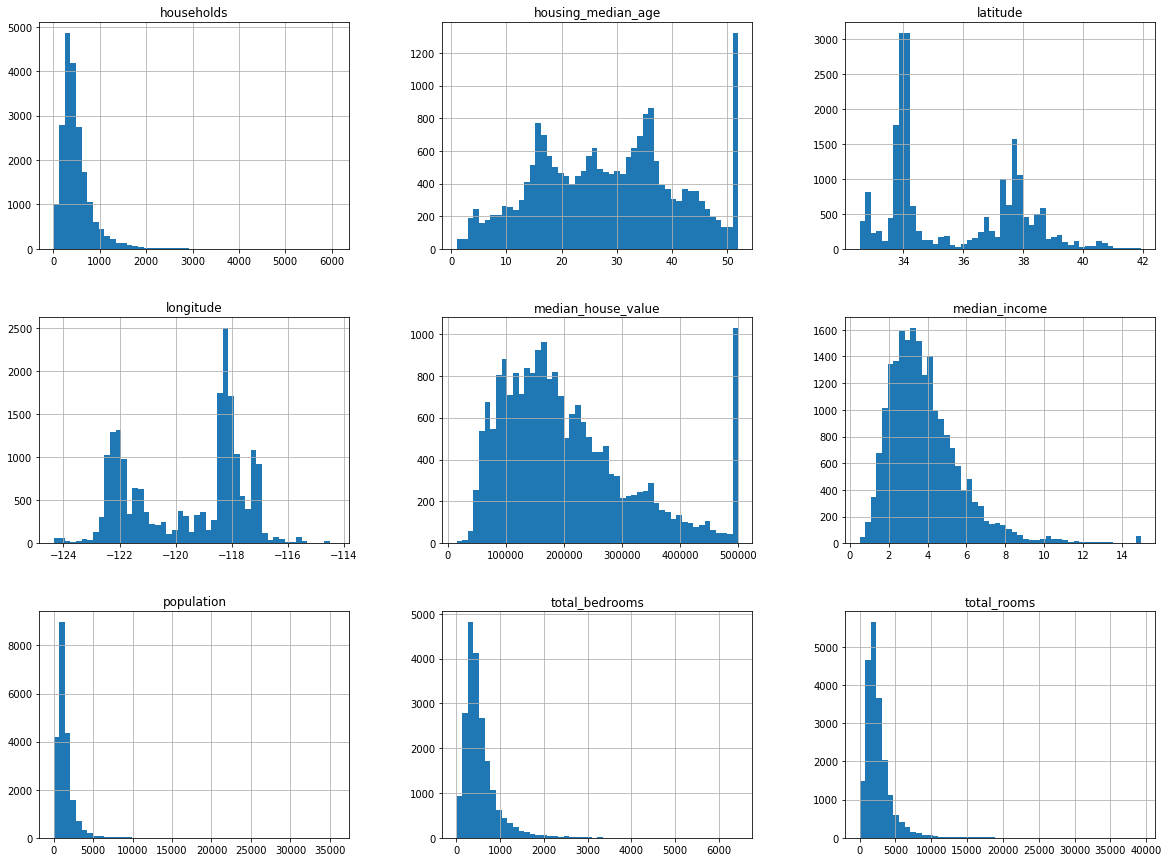

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
housing = housing_data
housing.hist(bins=50,figsize=(20,15))


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [0]:
import hashlib
import numpy as np
def test_set_check(identifier, test_ratio, hash):
  return hash(np.int64(identifier)).digest()[-1]<256*test_ratio
def split_train_test_by_id(data, test_ratio, id_column,hash=hashlib.md5):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_:test_set_check(id_,test_ratio,hash))
  return data.loc[~in_test_set],data.loc[in_test_set]


In [0]:
housing_with_id=housing.reset_index()
train_set,test_set = split_train_test_by_id(housing_with_id,0.2,"index")

In [0]:
from sklearn.model_selection import train_test_split
train_set,test_set = train_test_split(housing,test_size=0.2,random_state=42)

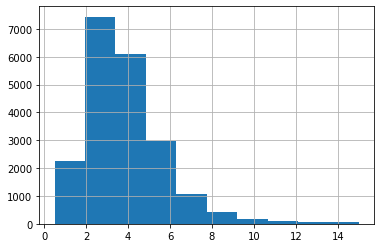

In [10]:
housing["median_income"].hist()

In [0]:
#reducing the number of strate
import numpy as np
housing["income_cat"]=np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"]<5,5.0,inplace=True)

In [0]:
#sampling based on income
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index,test_index in split.split(housing,housing["income_cat"]):
  strat_train_set=housing.loc[train_index]
  strat_test_set=housing.loc[test_index]

In [0]:
for set in (strat_train_set,strat_test_set):
  set.drop(["income_cat"],axis=1,inplace=True)

In [0]:
housing = strat_test_set.copy()

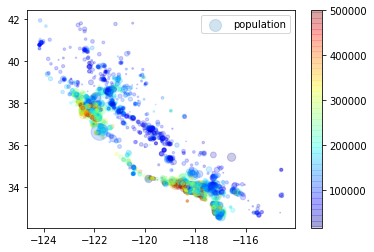

In [15]:
plt.scatter(housing["longitude"],housing["latitude"],alpha=0.2,s=housing["population"]/100,label="population",c=housing["median_house_value"],cmap=plt.get_cmap("jet"))
plt.legend()
plt.colorbar()

In [0]:
corr_matrix=housing.corr()

In [17]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.691831
total_rooms           0.131435
housing_median_age    0.071357
households            0.071242
total_bedrooms        0.057568
population           -0.016033
longitude            -0.039987
latitude             -0.150124
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4bf72d5be0>,
      dtype=object)

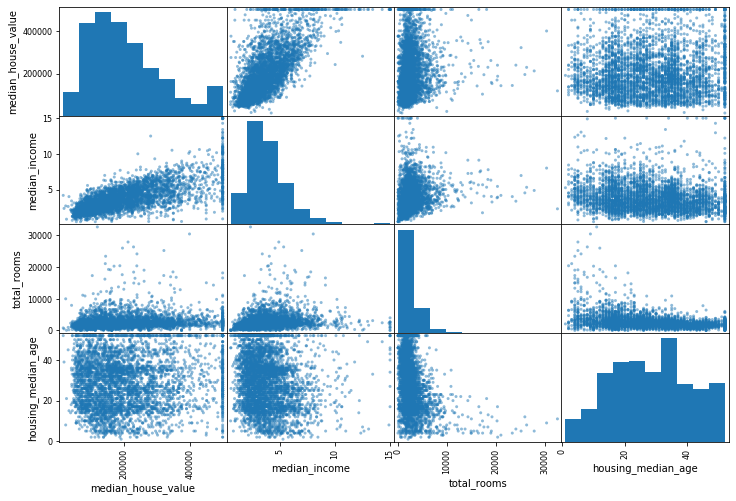

In [18]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value","median_income","total_rooms","housing_median_age"]
scatter_matrix(housing[attributes],figsize=(12,8))

In [0]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"]=housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [20]:
housing.corr()["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.691831
rooms_per_household         0.192575
total_rooms                 0.131435
housing_median_age          0.071357
households                  0.071242
total_bedrooms              0.057568
population                 -0.016033
longitude                  -0.039987
population_per_household   -0.135142
latitude                   -0.150124
bedrooms_per_room          -0.240362
Name: median_house_value, dtype: float64

In [0]:
housing=strat_test_set.drop("median_house_value",axis=1)
housing_labels=strat_train_set["median_house_value"].copy()

In [0]:
################# DATA CLEANING ##################################################

In [0]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [29]:
housing_num = housing.drop("ocean_proximity",axis=1)
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [0]:
X = imputer.transform(housing_num)

In [0]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [39]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
np.unique(housing_cat_encoded)

array([0, 1, 2, 3, 4])

In [41]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
from sklearn.base import BaseEstimator,TransformerMixin
rooms_ix, bedrooms_ix,population_ix, households_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator,TransformerMixin):
  def __init__(self,add_bedrooms_per_room = True):
    self.add_bedrooms_per_room = add_bedrooms_per_room
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    rooms_per_household = X [:,rooms_ix]/X[:,households_ix]
    population_per_household = X[:,population_ix]/X[:,households_ix]
    if self.add_bedrooms_per_room:
      bedrooms_per_room = X[:,bedrooms_ix]/X[:,rooms_ix]
      return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room]
    else:
      return np.c_[X,rooms_per_household,population_per_household]

In [45]:
#############Transformation Pipeline##########################################

array([6447.0, 4159.0, 4357.0, ..., 3073.0, 5464.0, 1616.0], dtype=object)